# **Studi Rekomendasi : Anime Recommendetion dengan Content-Base Filtering**

Model rekomendasi yang dibuat menggunakan Content-Base Filtering. Sistem ini akan memberikan output top 10 rekomendasi anime berdasarkan rating, genre, dan nama.

## **Dataset**

Dataset yang digunakan ada 2(dua) yaitu anime.csv dan rating.csv yang bisa ditemukan di kaggle.com. Dataset ini memiliki memiliki beberapa atribut diantaranya :

**Anime.csv**


*   anime_id - unique id yang mengidentifikasikan sebuah anime
*   name - nama lengkap anime
*   genre - kategori anime
*   type - movie, TV, OVA, dan lain-lain
*   episodes - berapa banyak episode anime (1 jika movie)
*   rating - rata-rata rating anime kisaran 0-10 
*   members - jumlah member di sebuah komunitas grup anime

**Rating.csv**

*   user_id - non identifiable randomly generated user id.
*   anime_id - anime yang telah dinilai pengguna ini.
*   rating - rating dari 10 yang telah ditetapkan pengguna ini (-1 jika pengguna menontonnya tetapi tidak memberikan peringkat).



# **Import Library**



In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns
import re
import warnings
from scipy import stats as st
import matplotlib.lines as mlines

warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import sigmoid_kernel


# **Import File**

Disini saya akan mengimport file dari kaggle dan mendownloadnya langsung dataset _Anime Recommendation Database_ dalam sebuah file zip lalu unzip file tersebut ke dalam file content

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adityaaprianto","key":"8de57ea699a4d4b0c352c02179898a4d"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d CooperUnion/anime-recommendations-database

 68% 17.0M/25.0M [00:00<00:00, 33.7MB/s]
100% 25.0M/25.0M [00:00<00:00, 46.5MB/s]


In [5]:
!unzip /content/anime-recommendations-database.zip

Archive:  /content/anime-recommendations-database.zip
  inflating: anime.csv               
  inflating: rating.csv              


# **Membaca File dan explore data**

Setelah mengimport file, langkah selanjutnya saya akan membaca dataset anime.csv dan rating.csv lalu mencari tau missing value didalam dataset dan melakukan proses handling missing value.

In [6]:
anime_df = pd.read_csv('/content/anime.csv')
anime_df

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [7]:
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [8]:
anime_df.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [9]:
rating_df = pd.read_csv('/content/rating.csv')

In [10]:
rating_df

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


In [11]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [12]:
print(rating_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB
None


In [13]:
print("Anime missing values (%):\n")
print(round(anime_df.isnull().sum().sort_values(ascending=False)/len(anime_df.index),4)*100) 
print("="*30,"\n\nRating missing values (%):")
print(round(rating_df.isnull().sum().sort_values(ascending=False)/len(rating_df.index),4)*100)

Anime missing values (%):

rating      1.87
genre       0.50
type        0.20
members     0.00
episodes    0.00
name        0.00
anime_id    0.00
dtype: float64

Rating missing values (%):
rating      0.0
anime_id    0.0
user_id     0.0
dtype: float64


In [14]:
# deleting anime dengan rating 0
anime_df=anime_df[~np.isnan(anime_df["rating"])]

# filling mode value untuk genre dan type
anime_df['genre'] = anime_df['genre'].fillna(
anime_df['genre'].dropna().mode().values[0])

anime_df['type'] = anime_df['type'].fillna(
anime_df['type'].dropna().mode().values[0])

#mengecek nilai null kembali
anime_df.isnull().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

Judul anime harus di bersihkan dulu agar bisa memberikan rekomendasi yang tepat.

In [15]:
def nameCleaning(text):
    text = re.sub(r'&quot;', '', text)
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)
    
    return text

anime_df['name'] = anime_df['name'].apply(nameCleaning)

# **Merging DataFrame**

Setelah malakukan proses explore data, saya menggabungkan kedua file yakni anime.csv dan rating.csv kedalam satu dataframe baru dan mengganti beberapa atribut nama kolomnya

In [16]:
animeMerging =pd.merge(anime_df,rating_df,on='anime_id',suffixes= ['', '_user'])
animeMerging = animeMerging.rename(columns={'name': 'anime_title', 'rating_user': 'user_rating'})
animeMerging.head()

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,-1


Text(0, 0.5, 'User Rating count')

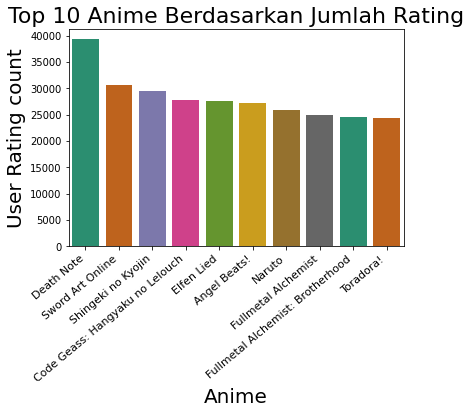

In [17]:
# Membuat sebuah dataframe untuk jumlah peringkat
combine_rating = animeMerging.dropna(axis = 0, subset = ['anime_title'])
ratingCount = (combine_rating.
     groupby(by = ['anime_title'])['user_rating'].
     count().
     reset_index().rename(columns = {'rating': 'totalRatingCount'})
    [['anime_title', 'user_rating']]
    )


top10_animerating=ratingCount[['anime_title', 'user_rating']].sort_values(by = 'user_rating',ascending = False).head(10)
ax=sns.barplot(x="anime_title", y="user_rating", data=top10_animerating, palette="Dark2")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11, rotation=40, ha="right")
ax.set_title('Top 10 Anime Berdasarkan Jumlah Rating',fontsize = 22)
ax.set_xlabel('Anime',fontsize = 20) 
ax.set_ylabel('User Rating count', fontsize = 20)

In [18]:
animeMerging = animeMerging.merge(ratingCount, left_on = 'anime_title', right_on = 'anime_title', how = 'left')
animeMerging = animeMerging.rename(columns={'user_rating_x': 'user_rating', 'user_rating_y': 'totalratingcount'})
animeMerging

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,user_rating,totalratingcount
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5,2199
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10,2199
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10,2199
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10,2199
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,-1,2199
...,...,...,...,...,...,...,...,...,...,...
7813716,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175,39532,-1,4
7813717,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175,48766,-1,4
7813718,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175,60365,4,4
7813719,26081,Yasuji no Pornorama: Yacchimae!!,Hentai,Movie,1,5.46,142,27364,-1,2


In [19]:
import plotly.graph_objects as go
labels = animeMerging['type'].value_counts().index
values = animeMerging['type'].value_counts().values
colors = ['blue', 'red', 'orange', 'green']
fig = go.Figure(data=[go.Pie(labels=labels,
                             values=values)])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.update_layout(
    title={
        'text': "Media Streaming",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

(-0.5, 799.5, 399.5, -0.5)

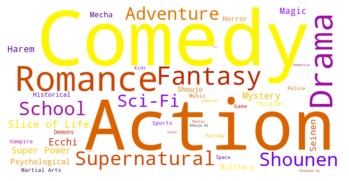

In [20]:
nonull_anime=animeMerging.copy()
nonull_anime.dropna(inplace=True)
from collections import defaultdict

all_genres = defaultdict(int)

for genres in nonull_anime['genre']:
    for genre in genres.split(','):
        all_genres[genre.strip()] += 1
        
from wordcloud import WordCloud

genres_cloud = WordCloud(width=800, height=400, background_color='white', colormap='gnuplot').generate_from_frequencies(all_genres)
plt.imshow(genres_cloud, interpolation='bilinear')
plt.axis('off')

# **Mengecek nilai null setelah merging data**

In [21]:
animeMerging.isnull().sum()

anime_id            0
anime_title         0
genre               0
type                0
episodes            0
rating              0
members             0
user_id             0
user_rating         0
totalratingcount    0
dtype: int64

## **Standarisasi Label Numerik**

Standardisasi adalah teknik transformasi yang paling umum digunakan dalam tahap persiapan pemodelan. Untuk fitur numerik. saya akan menggunakan teknik StandarScaler dari library Scikitlearn, StandardScaler melakukan proses standarisasi fitur dengan mengurangkan mean (nilai rata-rata) kemudian membaginya dengan standar deviasi untuk menggeser distribusi. StandardScaler menghasilkan distribusi dengan standar deviasi sama dengan 1 dan mean sama dengan 0

In [22]:
column_int = anime_df.dtypes[anime_df.dtypes == 'int64'].keys()
column_int

Index(['anime_id', 'members'], dtype='object')

In [23]:
# Memilih semua kolom dengan tipe data float
column_float = anime_df.dtypes[anime_df.dtypes == 'float64'].keys()
column_float

Index(['rating'], dtype='object')

In [24]:
# Menyatukan semua kolom dengan tipe data numerik
column_numeric = list(column_int) + list(column_float)
column_numeric

['anime_id', 'members', 'rating']

In [25]:
from sklearn.preprocessing import MinMaxScaler

# Inisiasi minmaxscaler
scaler = MinMaxScaler()

In [26]:
# Melakukan standarisasi data
scaled = scaler.fit_transform(anime_df[column_numeric])

In [27]:
# Mengganti data numerik dengan data yang sudah
# di standarisasi
i=0
for column in column_numeric:
    anime_df[column] = scaled[:,i]
    i += 1

# **Membuat Model Rekomendasi**

Model yang digunakan merupakan content base filtering dengan TF-ID Vectorizer.

In [28]:
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3),
            stop_words = 'english')

# Filling NaNs with empty string
anime_df['genre'] = anime_df['genre'].fillna('')
genres_str = anime_df['genre'].str.split(',').astype(str)
tfv_matrix = tfv.fit_transform(genres_str)

In [29]:
tfv_matrix.shape


(12064, 1547)

Scikit-learn menyediakan pairwise metrics yang berfungsi untuk representasi koleksi vektor yang padat dan jarang. Di sini fungsi perlu menetapkan 1 untuk anime yang direkomendasikan dan 0 untuk anime yang tidak direkomendasikan. Jadi penulis menggunakan kernel sigmoid

In [30]:
# Menghitung kesamaan menggunakan sigmoid_kernel
sig = sigmoid_kernel(tfv_matrix, tfv_matrix)

indices = pd.Series(anime_df.index, index=anime_df['name']).drop_duplicates()


# **Membuat Fungsi Rekomendasi**

Setalah membuat model, saya coba membuat fungsi give_rec yang dapat memberikan hasil rekomendasi top 10 anime 

In [31]:
def anime_rec(title, sig=sig):
    # Mendapatkan indeks yang sesuai dengan original_title
    idx = indices[title]

    # Mendapatkan pasangan similarity scores 
    sig_scores = list(enumerate(sig[idx]))

    # Mengurutkan movie 
    sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)

    # Skor dari 10 film yang paling mirip
    sig_scores = sig_scores[1:11]

    # mengindeks film
    anime_indices = [i[0] for i in sig_scores]

    # Membuat top 10 film paling mirip
    return pd.DataFrame({'Nama Anime': anime_df['name'].iloc[anime_indices].values, 'Genre': anime_df['genre'].iloc[anime_indices].values})

In [32]:
print('Nama anime : ', animeMerging.anime_title.unique())

Nama anime :  ['Kimi no Na wa.' 'Fullmetal Alchemist: Brotherhood' 'Gintama°' ...
 'Violence Gekiga David no Hoshi'
 'Violence Gekiga Shin David no Hoshi: Inma Densetsu'
 'Yasuji no Pornorama: Yacchimae!!']


# **Call Function Recommendation**

Setelah membuat model rekomendasi dengan content-base filtering, saatnya mencoba model yang telah dibuat dengan memanggil fungsi anime_rec() dan menampilkan top list rekomendasi.

In [33]:
print("Top 10 Anime Recommended: ")
anime_rec('One Piece')

Top 10 Anime Recommended: 


,Nama Anime,Genre
0,One Piece: Episode of Merry - Mou Hitori no Na...,"Action, Adventure, Comedy, Drama, Fantasy, Sho..."
1,One Piece: Episode of Nami - Koukaishi no Nami...,"Action, Adventure, Comedy, Drama, Fantasy, Sho..."
2,One Piece: Episode of Sabo - 3 Kyoudai no Kizu...,"Action, Adventure, Comedy, Drama, Fantasy, Sho..."
3,One Piece Film: Strong World,"Action, Adventure, Comedy, Drama, Fantasy, Sho..."
4,One Piece Film: Z,"Action, Adventure, Comedy, Drama, Fantasy, Sho..."
5,One Piece Film: Gold,"Action, Adventure, Comedy, Drama, Fantasy, Sho..."
6,One Piece: Heart of Gold,"Action, Adventure, Comedy, Drama, Fantasy, Sho..."
7,Digimon Frontier,"Action, Adventure, Comedy, Drama, Fantasy, Sho..."
8,Digimon Tamers,"Adventure, Comedy, Drama, Fantasy, Shounen"
9,Digimon Savers,"Adventure, Comedy, Drama, Fantasy, Shounen"


**Evaluation**

Hasil rekomendasi yang didapatkan sebanyak 7 item yang relevan dari 10 item yang direkomendasikan sesuai dengan judul anime dan genre. Dengan menggunakan metriks precision didapatkan hasil presisinya sebagai berikut:

 P = 7 / 10

 P = 70%

Hasil presisi nya sebesar 70%. Ini berarti sistem rekomendasi yang dibuat sudah cukup baik dalam memberikan Top-N Recommendation
